# Some imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from IPython.display import display, clear_output
import itertools
import math



import pylab
import random


# Visualization

In [2]:
def snapshot(ps, T, hist):
    
    hi = np.histogram(hist,50)
    pylab.gcf().set_size_inches(30, 15)
    pylab.subplot(121)
    #pylab.subplots_adjust(left=0.10, right=0.90, top=0.90, bottom=0.10)
    
    
    
    pylab.axis([0, 5, 0, 5])
    pylab.setp(pylab.gca(), xticks=[0, 1], yticks=[0, 1])
    for p in ps:
        if p.q > 0 : color = "red"
        if p.q < 0 : color = "blue"
        if p.q == 0 : color = "grey"
        circle = pylab.Circle((p.x, p.y), radius=p.m / 20.0, fc=color)
        pylab.gca().add_patch(circle)
       # pylab.gca().text(p.x ,p.y , str(p.id)) # + "\n" + str(round(p.Fx,1))  + "\n" + str(round(p.Fy,1))) # add text at particle position
        pylab.gca().text(0,0,"Temperature: "+str(round(sum([ p.m * (p.Vx**2 + p.Vx**2) for p in ps]) / len(ps),2)))
        pylab.gca().text(0,0.15,"Target: "+str(round(T,2)))
    pylab.subplot(122).plot(hi[1][1:], hi[0])
    pylab.show()
    
    clear_output(wait=True)
    #pylab.savefig(os.path.join(output_dir, '%d.png' % img), transparent=True)
    pylab.close()

# Some basic constants

In [13]:
N = 5

max_x = 2
max_y = 2
dt = 0.002

# The particle object

In [4]:
class particle(object):
    """Represents one object in the field."""
    def __init__(self,id,x=0,y=0,q=0,m = 1, color = "black", vx = 0, vy = 0, fx = 0, fy = 0):
        self.x = x
        self.y = y
        self.q = q
        self.m = m
        self.Vx = vx
        self.Vy = vy
        self.Fx = fx
        self.Fy = fy
        self.id = id
        self.color = color
    #def __repr__(self):
     #   return str(self.id)

# Functions for MD

In [6]:
def pbc(p1,p2):
    """return the minimal difference between x and y respecting the pbc"""
    x = max_x
    y = max_x
    for test in [(p1.x - p2.x), (p1.x - p2.x + max_x), (p1.x - p2.x - max_x)]:
        if abs(test) <= abs(x): 
            x = test
    for test in [(p1.y - p2.y), (p1.y - p2.y + max_y), (p1.y - p2.y - max_y)]:
        if abs(test) < abs(y): 
            y = test
    return x, y

def Coulomb(ps):
    """takes a pair of particles and changes their coordinates and velocities"""
    
    # coulomb forces Fx = -dU/dx
    e = 1
    
    p1 = ps[0]
    p2 = ps[1]

    # select the appropriate x, y for pbc force calc
    x, y = pbc(p1, p2)
    
    Fx = e*( p1.q * p2.q) * (x) / (((x)**2 + (y)**2)**1.5)
    Fy = e*( p1.q * p2.q) * (y) / (((x)**2 + (y)**2)**1.5)

    p1.Vx += Fx / p1.m * dt
    p1.Vy += Fy / p1.m * dt
    p2.Vx -= Fx / p2.m * dt
    p2.Vy -= Fy / p2.m * dt

def Bonds(ps):
    k = 50
    p1 = ps[0]
    p2 = ps[1]
    x, y = pbc(p1, p2)
    r = math.sqrt(x**2 + y**2)
    
    Fx = k * x
    Fy = k * y 
    if r >= (p1.m + p2.m) / 20.0:
        p1.Vx -= Fx / p1.m * dt
        p1.Vy -= Fy / p1.m * dt
        p2.Vx += Fx / p2.m * dt
        p2.Vy += Fy / p2.m * dt

       

        
def LJ(ps):
    e = 0.0004
    p1 = ps[0]
    p2 = ps[1]
    r0 = (p1.m + p2.m) / 200
    x, y = pbc(p1, p2)
    r = math.sqrt(x**2 + y**2)
    
    # calculate new LJ force
    Fx = e * ( 12 * r0**12 / r**13 - 6 * r0**6 / r**7 ) * x
    Fy = e * ( 12 * r0**12 / r**13 - 6 * r0**6 / r**7 ) * y 
    
    # update the velocities 
    p1.Vx += Fx / p1.m * dt 
    p1.Vy += Fy / p1.m * dt 
    p2.Vx -= Fx / p2.m * dt
    p2.Vy -= Fy / p2.m * dt 
    
    # and forces (not used right now)
    #p1.Fx = Fx 
    #p1.Fy = Fy
    #p2.Fx = Fx
    #p2.Fy = Fy 
    

def Move(ps):
    # integrates speed
    for p in ps:           
        p.x += p.Vx * dt / 2
        if p.x >= max_x or p.x < 0: p.x = p.x % max_x
     
        p.y += p.Vy * dt / 2
        if p.y >= max_y or p.y < 0: p.y = p.y % max_y

            
            
def Thermo(ps, Tref):     
    """controls the velocities of particles"""
    eps = 0.5
    tau = 1.0 # time scale factor

  
    Tnow = sum([p.m * (p.Vx**2 + p.Vy**2) for p in ps]) / len(ps)
    Tnext = Tnow + (Tref - Tnow) / tau #* dt

    #for p in ps:
     #   p.Vx *= math.sqrt(Tnext / Tnow)
      #  p.Vy *= math.sqrt(Tnext / Tnow)
    # bad thermostat
    dT = sum([p.m * (p.Vx**2 + p.Vy**2) for p in ps])/ len(ps)
    for p in ps:
        p.Vx *=  math.sqrt(Tref / dT)
        p.Vy *= math.sqrt(Tref / dT)

        
  


    
    
def pr(ps):
    for p in ps:
        print p.color
        print "velocities"
        print str(p.Vx) + " " + str(p.Vy)
        print "xy"
        print str(p.x) + " " + str(p.y)
        print 
        print math.sqrt((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2)
        print

# Simulation setup

In [7]:
step_x = max_x / math.sqrt(N)
step_y = max_y / math.sqrt(N)
xs = [step_x/2.0 + step_x * a for a in range(int(math.ceil(math.sqrt(N))))]
ys = [step_y/2.0 + step_y * a for a in range(int(math.ceil(math.sqrt(N))))]
coords = [a for a in itertools.product(xs,ys)]
xs = [x[0] for x in coords]
ys = [y[1] for y in coords]
#xs = [2.5, 2.5, 1]
#ys = [0.1, 4.9, 2]
qs = [random.choice([-1,1]) for a in range(N)]
ms = [random.uniform(0.5,1)*1 for a in range(N)]

vxs = [0 for a in range(N)]
vys = [0 for a in range(N)]
vxs = [random.uniform(-1,1)*max_x/25 for a in range(N)]
vys = [random.uniform(-1,1)*max_y/25 for a in range(N)]
cs = [(random.random(),random.random(),random.random()) for a in range(N)]

particles = [particle(i, x, y, q, color = c, m = m, vx = vx, vy = vy)\
             for i, x, y, q, c, m, vx, vy in zip(range(N), xs, ys, qs, cs, ms, vxs,vys)]
bonded = [99, 99] 

# Production cycle

In [12]:
T = 100
hist = []
term = True
grow = True
bonded = [[0,1], [0,2], [3,4], [3,5], [6,7], [6,8], [9,11], [9,10], [11,12], [11,13]]
for tt in range(1000000):
    # move half a step
    Move(particles)
    # the forces are pairwise
    for ps in itertools.combinations(particles, 2):
        x,y = pbc(ps[0], ps[1])
        if [particles.index(p) for p in ps] in bonded:
            Bonds(ps)  
        if (x)**2 + (y)**2 < (max_x**2 + max_y**2)/4: # cutoff
            LJ(ps)
            Coulomb(ps)
   
    if term and tt % 1 == 0: Thermo(particles, T)  
    # move another half step
    Move(particles)    
   
   
        
    if tt % 1 == 0:
        if tt > 10000: hist+=[math.sqrt(p.Vx**2 + p.Vy**2) for p in particles]
        snapshot(particles, T, hist)
    if tt == 394100: break

KeyboardInterrupt: 

In [ ]:
sum([p.Vx**2 + p.Vy**2 for p in particles]) - T

In [366]:
hist_bad = list(hist)
hib = np.histogram(hist_bad,50)

hig = np.histogram(hist_good,50)

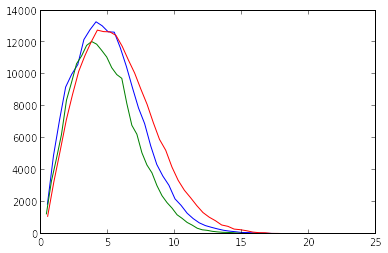

In [375]:
pylab.plot(hig[1][1:], hig[0])
pylab.plot(hib[1][1:], hib[0])
pylab.plot(hisg[1][1:], hisg[0],)

In [374]:
hisg = np.histogram([math.sqrt(random.gauss(2,3) ** 2 + random.gauss(3,4) ** 2) for a in range(int(394100/50.0)*25)],50)

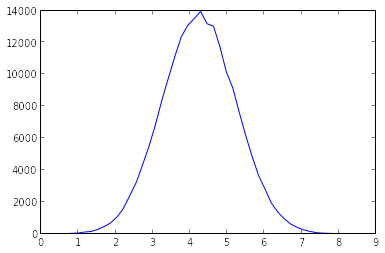

In [363]:
pylab.plot(hig[1][1:], hig[0])

ValueError: third arg must be a format string

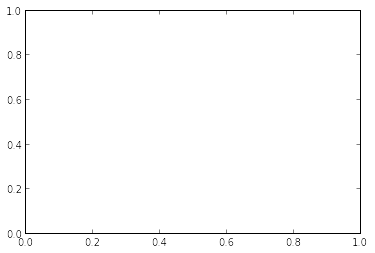

In [317]:
pylab.plot(np.histogram(hist)[1][1:],np.histogram(hist)[0], 50)

In [155]:
a,b = np.histogram(hist, 9)[1], np.histogram(hist, 9)[0]

In [357]:
394100/50.0

7882.0

In [152]:
sum(np.histogram(hist, 9)[0])

25

In [295]:
rom mayavi import mlab
import numpy as np
from scipy.special import sph_harm

# Create a sphere
r = 0.3
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0:pi:101j, 0:2 * pi:101j]

x = r * sin(phi) * cos(theta)
y = r * sin(phi) * sin(theta)
z = r * cos(phi)

mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(400, 300))
mlab.clf()
# Represent spherical harmonics on the surface of the sphere
for n in range(1, 6):
    for m in range(n):
        s = sph_harm(m, n, theta, phi).real

        mlab.mesh(x - m, y - n, z, scalars=s, colormap='jet')

        s[s < 0] *= 0.97

        s /= s.max()
        mlab.mesh(s * x - m, s * y - n, s * z + 1.3,
                  scalars=s, colormap='Spectral')

mlab.view(90, 70, 6.2, (-1.3, -2.9, 0.25))
mlab.show()


SyntaxError: invalid syntax (<ipython-input-295-6475bb772420>, line 1)